# SMS Spam Classification

This notebook uses different techniques to classify SMS messages as spam or not spam. The dataset used is the [SMS Spam Collection Dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset) from Kaggle.

The dataset is first opened with pandas and the columns are represented with the right variables.

In [59]:
import pandas as pd
import numpy as np

df = pd.read_csv('spam.csv', encoding='latin-1')
df = df.rename(columns={'v1': 'label', 'v2': 'message'})
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


The labels in the dataset are encoded to numerical values using the map function.

In [60]:
df['label_encoded'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,label,message,label_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


The labels are visualized using a pie chart to show their distribution.

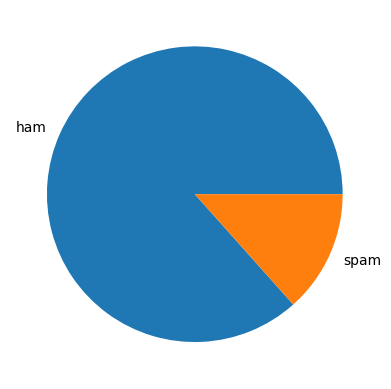

In [61]:
import matplotlib.pyplot as plt

plt.pie(df.label.value_counts(), labels=['ham', 'spam'])
plt.show()

The average number of words in a message is found.

In [62]:
avg_word_count = round(sum([len(i.split()) for i in df['message']]) / len(df['message']))
avg_word_count

15

The number of unique words in the dataset is found.

In [63]:
# Find the number of unique words in the dataset

word_set = set()
for i in df.message:
    for j in i.split():
        word_set.add(j)

total_words_length = len(word_set)
print(total_words_length)

15585


The data is split into training and testing sets using the train_test_split function from sklearn. The x values are the messages and the y values are the labels.

In [64]:
# Split the dataset into testing and training sets

from sklearn.model_selection import train_test_split

x = df['message']
y = df['label_encoded']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

We next vectorize the messages using the TF-IDF vectorizer. The TF-IDF vectorizer will then transform the text into meaningful representation of integers or numbers which is used to fit machine learning algorithm for predictions. TF-IDF can be used to tell how important or relevant a word is in the document.

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer().fit(x_train)
x_train_vec, x_test_vec = tfidf_vec.transform(x_train), tfidf_vec.transform(x_test)

We create a base model using the Multinomial Naive Bayes classifier which is a popular algorithm for natural language processing. Note that the vectorized training set is used for training.

In [66]:
from sklearn.naive_bayes import MultinomialNB

baseline_model = MultinomialNB()
baseline_model.fit(x_train_vec, y_train)

MultinomialNB()

Prediction is done using this base model and the accuracy is found and displayed.

In [67]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = baseline_model.predict(x_test_vec)

nb_accuracy = accuracy_score(y_test, y_pred)
print(nb_accuracy)
print(classification_report(y_test, y_pred))

0.9623318385650225
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



The confusion matrix is calculated and displayed.

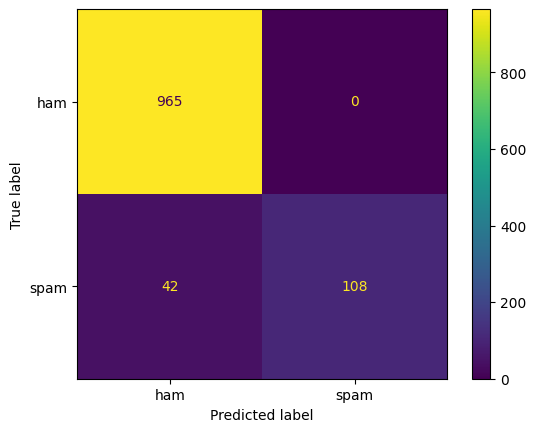

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=['ham', 'spam'])
fig.plot()

From the confusion matrix we can infer that the model has a high false positive rate.

Next we use a different vectorization tool from TensorFlow called the Keras Text Vectorization layer. This layer will vectorize the text into integers and then pad the text to make all the text the same length. 
* The **max_tokens** parameter is used to specify the maximum number of words to be used in the vocabulary. 
* The **standardize** parameter is used to specify any preprocessing to be done on the text. In this case we convert all the text to lowercase and remove punctuation.
* The **output_mode** parameter is used to specify the output of the vectorization layer.
* The **output_sequence_length** parameter is used to specify the length of the output sequence.

The vectorization layer is then adapted to the training data.

In [69]:
from tensorflow.keras.layers import TextVectorization

MAXTOKENS = total_words_length
OUTPUTLEN = avg_word_count

text_vec = TextVectorization(max_tokens=MAXTOKENS,
                            standardize='lower_and_strip_punctuation',
                            output_mode='int',
                            output_sequence_length=OUTPUTLEN)

text_vec.adapt(x_train)

Next we define an Embedding layer which is a layer in TensorFlow Keras that is used to represent words as vectors of numbers. Embedding layers are used to show the relationships between words which can be used for deep learning tasks such as text classification.

In [70]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)

We then define a set of user defined helper functions to create a model, train the model, and evaluate the model. These can be used for all future models created in this notebook.

In [71]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow import keras

def compile_model(model):
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])


def fit_model(model, epochs, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    history = model.fit(x_train, y_train, epochs=epochs, validation_data=(
        x_test, y_test), validation_steps=int(0.2*len(x_test)))
    return history


def evaluate_model(model, X, y):
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)
    model_results_dict = {'accuracy': accuracy,
                          'precision': precision,
                          'recall': recall,
                          'f1-score': f1}

    return model_results_dict

## Model 1

In [72]:
import tensorflow as tf
from tensorflow import keras

input_layer = keras.layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = keras.layers.GlobalAveragePooling1D()(embedding_layer_model)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(32, activation='relu')(x)
output_layer = keras.layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

In [73]:
compile_model(model_1)
history_1 = fit_model(model_1, epochs=5)

Epoch 1/5
140/140 [==============================] - 4s 21ms/step - loss: 0.3266 - accuracy: 0.8972 - val_loss: 0.1206 - val_accuracy: 0.9695
Epoch 2/5
140/140 [==============================] - 3s 20ms/step - loss: 0.0750 - accuracy: 0.9791 - val_loss: 0.0642 - val_accuracy: 0.9830
Epoch 3/5
140/140 [==============================] - 3s 20ms/step - loss: 0.0349 - accuracy: 0.9919 - val_loss: 0.0536 - val_accuracy: 0.9848
Epoch 4/5
140/140 [==============================] - 3s 20ms/step - loss: 0.0195 - accuracy: 0.9955 - val_loss: 0.0509 - val_accuracy: 0.9857
Epoch 5/5
140/140 [==============================] - 3s 21ms/step - loss: 0.0129 - accuracy: 0.9971 - val_loss: 0.0530 - val_accuracy: 0.9848


## Model 2

In [74]:
from tensorflow.keras import layers

input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

In [75]:
compile_model(model_2)
history_2 = fit_model(model_2, epochs=5)

Epoch 1/5
140/140 [==============================] - 13s 46ms/step - loss: 0.0478 - accuracy: 0.9838 - val_loss: 0.0843 - val_accuracy: 0.9794
Epoch 2/5
140/140 [==============================] - 5s 36ms/step - loss: 0.0074 - accuracy: 0.9978 - val_loss: 0.0633 - val_accuracy: 0.9803
Epoch 3/5
140/140 [==============================] - 5s 36ms/step - loss: 0.0050 - accuracy: 0.9989 - val_loss: 0.0632 - val_accuracy: 0.9821
Epoch 4/5
140/140 [==============================] - 5s 36ms/step - loss: 0.0011 - accuracy: 0.9993 - val_loss: 0.0802 - val_accuracy: 0.9830
Epoch 5/5
140/140 [==============================] - 5s 36ms/step - loss: 5.3893e-05 - accuracy: 1.0000 - val_loss: 0.0887 - val_accuracy: 0.9848


## Model 3

In [76]:
import tensorflow_hub as hub

model_3 = keras.Sequential()
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False, input_shape=[], dtype=tf.string, name='USE')
model_3.add(use_layer)
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(64, activation=keras.activations.relu))
model_3.add(layers.Dense(1, activation=keras.activations.sigmoid))

In [77]:
compile_model(model_3)
history_3 = fit_model(model_3, epochs=5)

Epoch 1/5
140/140 [==============================] - 4s 16ms/step - loss: 0.2684 - accuracy: 0.9248 - val_loss: 0.1024 - val_accuracy: 0.9695
Epoch 2/5
140/140 [==============================] - 2s 12ms/step - loss: 0.0761 - accuracy: 0.9814 - val_loss: 0.0681 - val_accuracy: 0.9803
Epoch 3/5
140/140 [==============================] - 2s 12ms/step - loss: 0.0541 - accuracy: 0.9843 - val_loss: 0.0598 - val_accuracy: 0.9830
Epoch 4/5
140/140 [==============================] - 2s 12ms/step - loss: 0.0467 - accuracy: 0.9854 - val_loss: 0.0564 - val_accuracy: 0.9803
Epoch 5/5
140/140 [==============================] - 2s 12ms/step - loss: 0.0412 - accuracy: 0.9877 - val_loss: 0.0523 - val_accuracy: 0.9848


## Model Analysis

We use the helper functions to evaluate the models.

In [78]:
baseline_model_results = evaluate_model(baseline_model, x_test_vec, y_test)
model_1_results = evaluate_model(model_1, x_test, y_test)
model_2_results = evaluate_model(model_2, x_test, y_test)
model_3_results = evaluate_model(model_3, x_test, y_test)

total_results = pd.DataFrame({'MultinomialNB Model': baseline_model_results,
                             'Custom-Vec-Embedding Model': model_1_results,
                              'Bidirectional-LSTM Model': model_2_results,
                              'USE-Transfer learning Model': model_3_results}).transpose()

total_results

35/35 [==============================] - 1s 6ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.981166,0.944828,0.913333,0.928814
Bidirectional-LSTM Model,0.984753,0.958621,0.926667,0.942373
USE-Transfer learning Model,0.984753,0.940397,0.946667,0.943522


<Axes: >

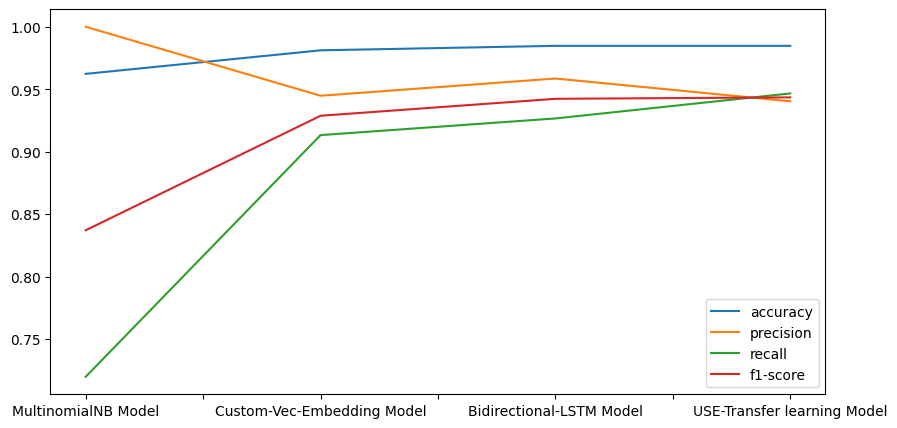

In [98]:
total_results.plot(figsize=(10, 5))